# Introduction to CNN

CNN Microscopy Segmentation 

This notebook teaches **beginner CNN segmentation** for microscopy images.

**Core goals:**
- Learn how to create masks using OpenCV
- Train a CNN for multi-class segmentation (TensorFlow)
- Evaluate using Dice & IoU
- Improve outputs


In [1]:
## Import Required Libraries

# Operating system utilities (file paths, directory listing)
import os

# Numerical computing
import numpy as np

# Image processing with OpenCV
import cv2

# Plotting and visualization
import matplotlib.pyplot as plt

# TensorFlow / Keras for CNNs
import tensorflow as tf
from tensorflow.keras import layers, models

# Metrics helpers
from sklearn.model_selection import train_test_split


c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## 3. Dataset Structure

Expected folder structure:
```
Microscopy_Dataset/
 ├── images/   (.JPG microscopy images)
 └── masks/    (.png masks – generated if missing)
```

Important: Masks **do not originally exist** and must be created using OpenCV.
"""


In [2]:

# Define base directory containing images and masks
BASE_DIR = "C:\\Users\\admin\\Desktop\\HPC_ML Course\\"

# Path to raw microscopy images
IMAGE_DIR = os.path.join(BASE_DIR, '100_images')

# Path where masks will be stored or loaded
MASK_DIR = os.path.join(BASE_DIR, 'masks')

# Create mask directory if it does not already exist
os.makedirs(MASK_DIR, exist_ok=True)

## 4. Multi-Class Mask Generation using OpenCV

We generate **weak labels** using image intensity and morphology.

Class definitions:
- 0 → Background
- 1 → Small pores
- 2 → Large pores


In [3]:
def generate_mask(image_path, save_path):
    """
    Generate a multi-class segmentation mask using Otsu's thresholding
    and contour area analysis.
    """
    # Load image in grayscale mode
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply Gaussian blur to reduce noise
    blur = cv2.GaussianBlur(img, (5, 5), 0)

    # Use Otsu's method to automatically find threshold
    _, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Initialize mask with background class (0)
    mask = np.zeros_like(blur, dtype=np.uint8)
    mask[binary == 255] = 2  # All pores start as class 2 (large pores)

    # Separate by size using contour analysis
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        area = cv2.contourArea(contour)
        if area < 50:  # Small pores threshold
            cv2.drawContours(mask, [contour], -1, 1, -1)
        # else: stays as 2 (large pores)

    # Morphological opening to remove noise
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Save generated mask
    cv2.imwrite(save_path, mask)
    return mask


## 4.1 Analyze Sample Image Intensity Distribution

### Check if images directory exists and has files

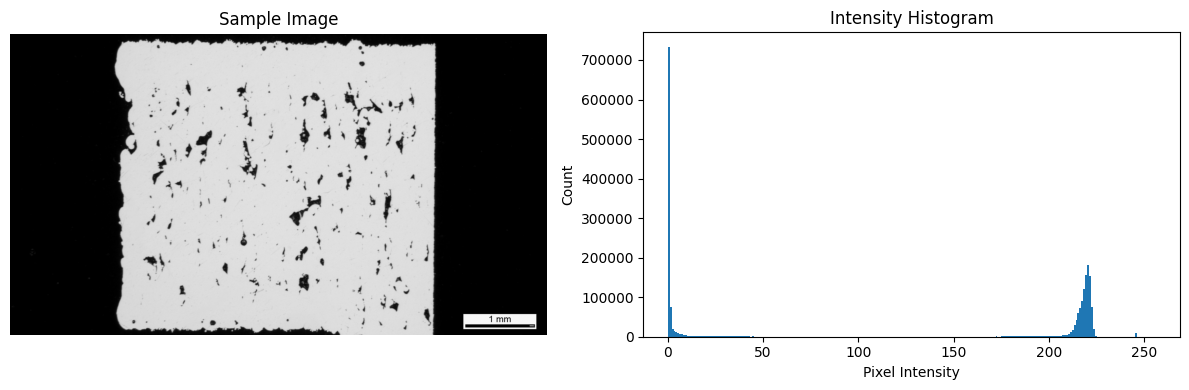

Min intensity: 0
Max intensity: 252
Mean intensity: 118.7
Found 150 images


In [4]:
if not os.path.exists(IMAGE_DIR):
    print(f"ERROR: Image directory not found at {IMAGE_DIR}")
    print("Please update BASE_DIR to point to your dataset location")
else:
    image_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith('.JPG')]

    if len(image_files) == 0:
        print(f"ERROR: No .JPG files found in {IMAGE_DIR}")
    else:
        # Load first sample image
        sample_img = cv2.imread(os.path.join(IMAGE_DIR, image_files[0]), cv2.IMREAD_GRAYSCALE)

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(sample_img, cmap='gray')
        plt.title('Sample Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.hist(sample_img.ravel(), bins=256, range=[0, 256])
        plt.title('Intensity Histogram')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()

        print(f"Min intensity: {sample_img.min()}")
        print(f"Max intensity: {sample_img.max()}")
        print(f"Mean intensity: {sample_img.mean():.1f}")
        print(f"Found {len(image_files)} images")

## 4.2 Generate All Masks

### Generate masks for all images

In [5]:
print("Generating masks...")
mask_count = 0
for fname in os.listdir(IMAGE_DIR):
    if fname.endswith('.JPG'):
        img_path = os.path.join(IMAGE_DIR, fname)
        mask_path = os.path.join(MASK_DIR, fname.replace('.JPG', '.png'))

        # Generate mask if it doesn't exist
        if not os.path.exists(mask_path):
            generate_mask(img_path, mask_path)
            mask_count += 1

print(f"Generated {mask_count} new masks")

Generating masks...
Generated 150 new masks


## 4.3 Visualize Generated Masks

### Visualize a few masks

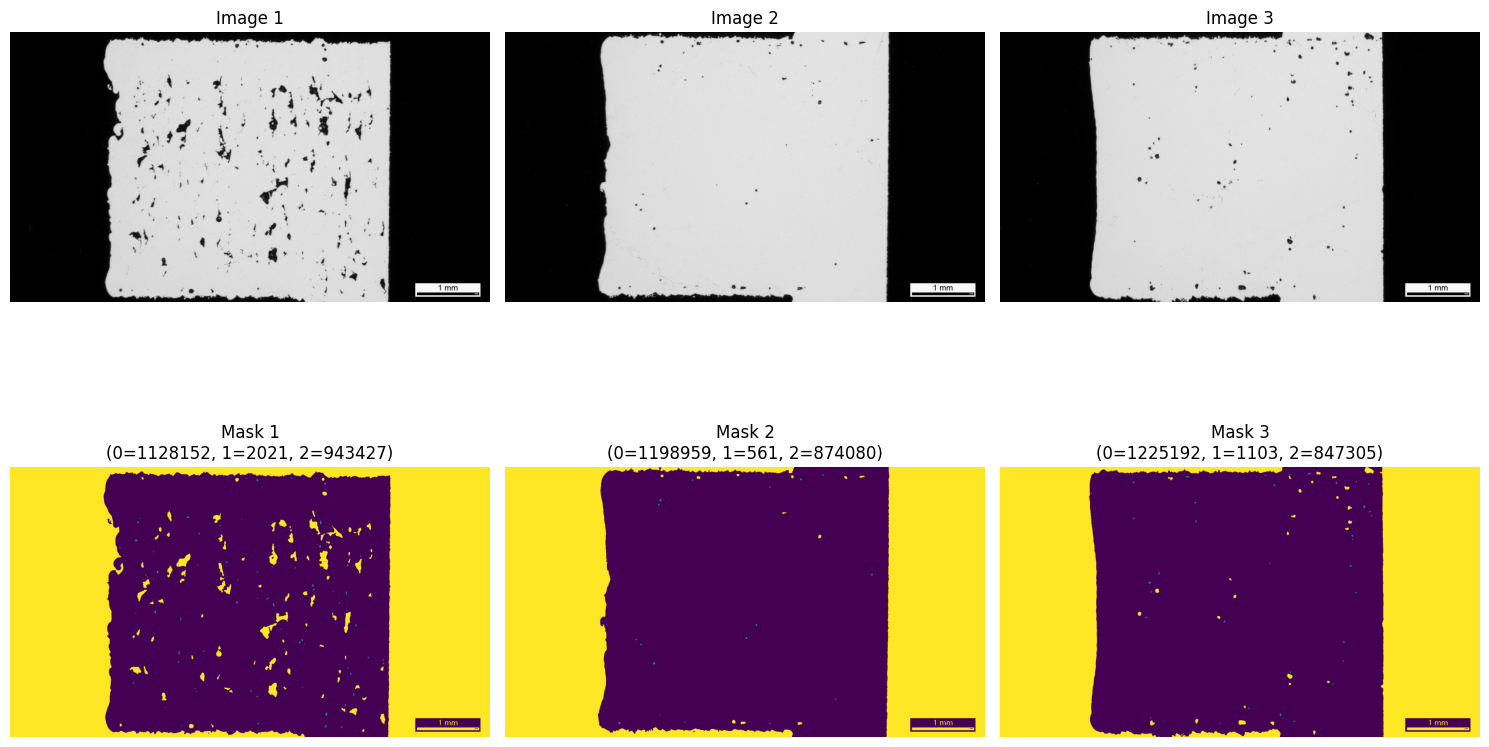

In [6]:
image_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith('.JPG')][:3]

if len(image_files) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    for i, fname in enumerate(image_files):
        img = cv2.imread(os.path.join(IMAGE_DIR, fname), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(MASK_DIR, fname.replace('.JPG', '.png')), cv2.IMREAD_GRAYSCALE)

        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f'Image {i+1}')
        axes[0, i].axis('off')

        axes[1, i].imshow(mask, cmap='viridis')
        class_counts = f'0={np.sum(mask==0)}, 1={np.sum(mask==1)}, 2={np.sum(mask==2)}'
        axes[1, i].set_title(f'Mask {i+1}\n({class_counts})')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

## 5. Load Images and Masks

In [7]:
images = []
masks = []

# Iterate over each image file
for fname in os.listdir(IMAGE_DIR):
    if fname.endswith('.JPG'):
        img_path = os.path.join(IMAGE_DIR, fname)
        mask_path = os.path.join(MASK_DIR, fname.replace('.JPG', '.png'))

        # Load and resize image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (256, 256))

        # Load and resize mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        images.append(img)
        masks.append(mask)

# Convert lists to NumPy arrays
X = np.array(images)[..., np.newaxis] / 255.0
y = np.array(masks)

print(f"Loaded {len(images)} images")
print(f"Image shape: {X.shape}")
print(f"Mask shape: {y.shape}")

Loaded 150 images
Image shape: (150, 256, 256, 1)
Mask shape: (150, 256, 256)


## 6. Train / Validation / Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 90
Test samples: 60


## 7. CNN Model (TensorFlow)

In [9]:
# Check class distribution to detect imbalance
unique, counts = np.unique(y_train, return_counts=True)
class_dist = dict(zip(unique, counts))
print(f"Class distribution in training data: {class_dist}")

# Calculate class weights to handle imbalance
total_pixels = y_train.size
class_weights = {}
for class_id in unique:
    # Inverse of frequency for class weighting
    class_weights[int(class_id)] = total_pixels / (len(unique) * counts[class_id])
print(f"Class weights: {class_weights}")

# Build an improved U-Net style encoder-decoder CNN for segmentation
model = models.Sequential([
    layers.Input(shape=(256, 256, 1)),

    # Encoder (downsampling)
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.Conv2D(128, 3, activation='relu', padding='same'),

    # Decoder (upsampling)
    layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same'),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.Dropout(0.2),

    layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same'),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.Dropout(0.2),

    # Multi-class output (3 classes)
    layers.Conv2D(3, 1, activation='softmax')
])

# Compile model with appropriate loss and metric
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Class distribution in training data: {np.uint8(0): np.int64(3448573), np.uint8(1): np.int64(2596), np.uint8(2): np.int64(2447071)}
Class weights: {0: np.float64(0.5701140732703063), 1: np.float64(757.3497688751926), 2: np.float64(0.8034421559488875)}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 128, 128, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 256, 256, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 256, 256, 3)    │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 424,963 (1.62 MB)

 Trainable params: 424,963 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

## 8. Train the CNN

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.4349 - loss: 1.0056 - val_accuracy: 0.4469 - val_loss: 0.8233 - learning_rate: 0.0010
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 964ms/step - accuracy: 0.7007 - loss: 0.8245 - val_accuracy: 0.4852 - val_loss: 0.4872 - learning_rate: 0.0010
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 963ms/step - accuracy: 0.6227 - loss: 0.5626 - val_accuracy: 0.6230 - val_loss: 0.4434 - learning_rate: 0.0010
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 976ms/step - accuracy: 0.6301 - loss: 0.5337 - val_accuracy: 0.6032 - val_loss: 0.4230 - learning_rate: 0.0010
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 962ms/step - accuracy: 0.6474 - loss: 0.5238 - val_accuracy: 0.7091 - val_loss: 0.4134 - learning_rate: 0.0010
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 959ms/step - accuracy: 0.6763 - loss: 0.5193 - val_accuracy: 0.5718 - val_loss: 0.4140 - learning_rate: 0.0010
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 949ms/step - accuracy: 0.7056 - loss: 0.518

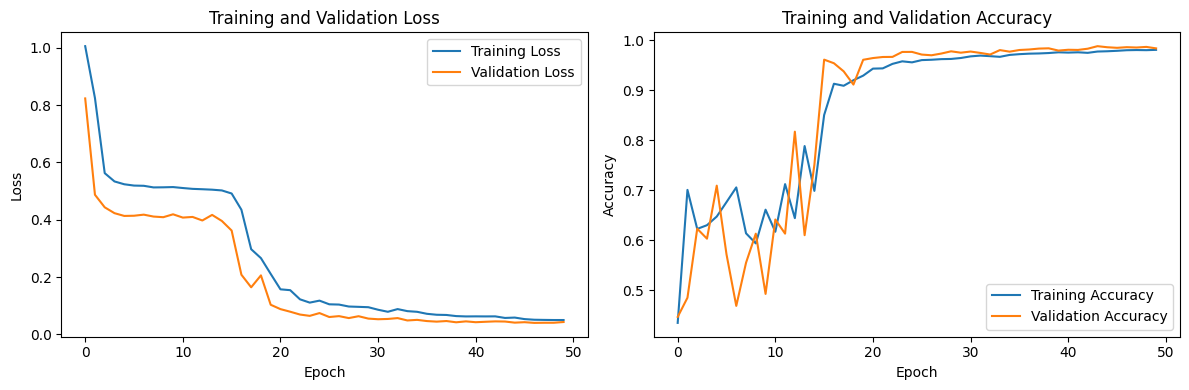

In [10]:
# Create a sample_weight array for pixel-wise class weighting
sample_weights_array = np.zeros_like(y_train, dtype=np.float32)
for class_id, weight in class_weights.items():
    sample_weights_array[y_train == class_id] = weight

# Add callbacks for better training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
]

# Train with sample weights and more epochs
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,  # Increased from 5
    batch_size=4,
    sample_weight=sample_weights_array, # Use sample_weight instead of class_weight
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

## 9. Test Evaluation

In [11]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')

# Dice coefficient implementation
def dice_score(y_true, y_pred, smooth=1e-6):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

# Intersection over Union (IoU)
def iou_score(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

# Predict on test set
y_pred_prob = model.predict(X_test)

# Convert probability maps to class labels
y_pred = np.argmax(y_pred_prob, axis=-1)

# Compute Dice and IoU per image
dice_scores = []
iou_scores = []
dice_per_class = {0: [], 1: [], 2: []}

for i in range(len(y_test)):
    # Overall binary (pore vs background)
    dice_scores.append(dice_score(y_test[i] > 0, y_pred[i] > 0))
    iou_scores.append(iou_score(y_test[i] > 0, y_pred[i] > 0))

    # Per-class metrics
    for class_id in [0, 1, 2]:
        dice_per_class[class_id].append(
            dice_score(y_test[i] == class_id, y_pred[i] == class_id)
        )

print(f'Mean Dice (overall): {np.mean(dice_scores):.4f}')
print(f'Mean IoU (overall): {np.mean(iou_scores):.4f}')
print(f'\nPer-class Dice scores:')
print(f'  Background (0): {np.mean(dice_per_class[0]):.4f}')
print(f'  Small pores (1): {np.mean(dice_per_class[1]):.4f}')
print(f'  Large pores (2): {np.mean(dice_per_class[2]):.4f}')

# Show prediction statistics
print(f'\nPrediction class distribution:')
for class_id in [0, 1, 2]:
    count = np.sum(y_pred == class_id)
    percentage = 100 * count / y_pred.size
    print(f'  Class {class_id}: {count} pixels ({percentage:.2f}%)')

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.9817 - loss: 0.0571
Test accuracy: 0.9817
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Mean Dice (overall): 0.9806
Mean IoU (overall): 0.9622

Per-class Dice scores:
  Background (0): 0.9855
  Small pores (1): 0.0578
  Large pores (2): 0.9932

Prediction class distribution:
  Class 0: 2242988 pixels (57.04%)
  Class 1: 58566 pixels (1.49%)
  Class 2: 1630606 pixels (41.47%)


## 10. Visualization

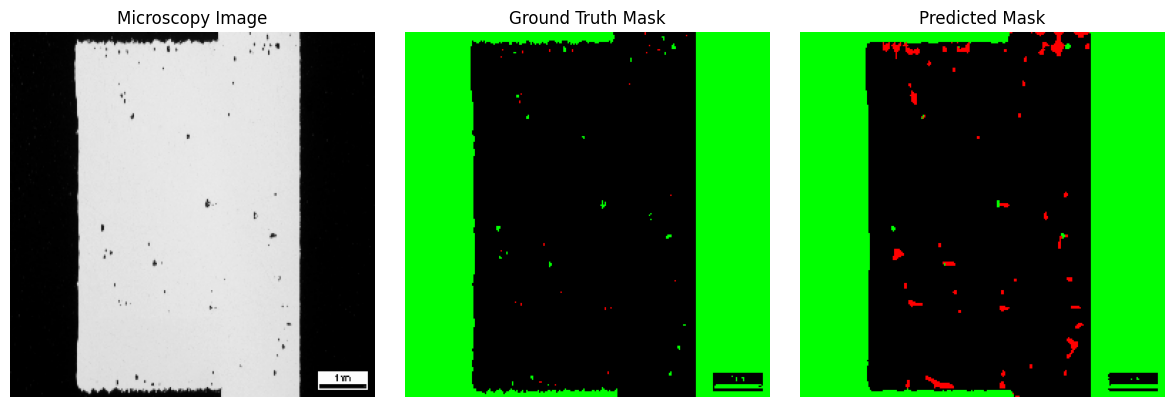

In [12]:
def colorize_mask(mask):
    """Convert class mask to RGB visualization"""
    rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    rgb[mask == 1] = [255, 0, 0]   # Small pores → Red
    rgb[mask == 2] = [0, 255, 0]   # Large pores → Green
    return rgb

# Visualize results
idx = min(9, len(X_test) - 1)  # Ensure valid index

image = X_test[idx].squeeze()
gt_mask = y_test[idx]
pred_mask = y_pred[idx]

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title('Microscopy Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Ground Truth Mask')
plt.imshow(colorize_mask(gt_mask))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Predicted Mask')
plt.imshow(colorize_mask(pred_mask))
plt.axis('off')

plt.tight_layout()
plt.show()